# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline
import seaborn as sns

In [2]:
#importing datasets
df = pd.read_csv('../Traffic_Crashes_-_Crashes.csv')
df_people = pd.read_csv('../Traffic_Crashes_-_People.csv')
df_vehicles = pd.read_csv('../Traffic_Crashes_-_Vehicles.csv')
df.head()

/Users/jerry_vasquez/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (12,13,20,21,22,23,24,25,26,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/jerry_vasquez/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,53,55,58,59,61,71) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,JC343143,NaN,07/10/2019 05:56:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,...,0.0,0.0,3.0,0.0,17,4,7,41.919664,-87.773288,POINT (-87.773287883007 41.919663832993)
1,009e9e67203442370272e1a13d6ee51a4155dac65e583d...,JA329216,NaN,06/30/2017 04:00:00 PM,35,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,...,0.0,0.0,3.0,0.0,16,6,6,41.741804,-87.740954,POINT (-87.740953581987 41.741803598989)
2,ee9283eff3a55ac50ee58f3d9528ce1d689b1c4180b4c4...,JD292400,NaN,07/10/2020 10:25:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,...,0.0,0.0,3.0,0.0,10,6,7,41.773456,-87.585022,POINT (-87.585022352022 41.773455972008)
3,f8960f698e870ebdc60b521b2a141a5395556bc3704191...,JD293602,NaN,07/11/2020 01:00:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DARKNESS,PARKED MOTOR VEHICLE,...,0.0,0.0,3.0,0.0,1,7,7,41.802119,-87.622115,POINT (-87.622114914961 41.802118543011)
4,8eaa2678d1a127804ee9b8c35ddf7d63d913c14eda61d6...,JD290451,NaN,07/08/2020 02:00:00 PM,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,...,0.0,0.0,1.0,0.0,14,4,7,NaN,NaN,NaN


In [3]:
df_vehicles.head()

,CRASH_UNIT_ID,CRASH_RECORD_ID,RD_NO,CRASH_DATE,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,...,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS
0,829999,24ddf9fd8542199d832e1c223cc474e5601b356f1d77a6...,JD124535,01/22/2020 06:25:00 AM,1,DRIVER,NaN,796949.0,NaN,INFINITI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,749947,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,09/28/2019 03:30:00 AM,1,DRIVER,NaN,834816.0,NaN,HONDA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,749949,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,09/28/2019 03:30:00 AM,2,PARKED,NaN,834819.0,NaN,TOYOTA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,749950,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,09/28/2019 03:30:00 AM,3,PARKED,NaN,834817.0,NaN,GENERAL MOTORS CORPORATION (GMC),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,871921,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,JD208731,04/13/2020 10:50:00 PM,2,DRIVER,NaN,827212.0,NaN,BUICK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567797 entries, 0 to 567796
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                567797 non-null  object 
 1   RD_NO                          563961 non-null  object 
 2   CRASH_DATE_EST_I               42926 non-null   object 
 3   CRASH_DATE                     567797 non-null  object 
 4   POSTED_SPEED_LIMIT             567797 non-null  int64  
 5   TRAFFIC_CONTROL_DEVICE         567797 non-null  object 
 6   DEVICE_CONDITION               567797 non-null  object 
 7   WEATHER_CONDITION              567797 non-null  object 
 8   LIGHTING_CONDITION             567797 non-null  object 
 9   FIRST_CRASH_TYPE               567797 non-null  object 
 10  TRAFFICWAY_TYPE                567797 non-null  object 
 11  LANE_CNT                       198975 non-null  float64
 12  ALIGNMENT                     

In [5]:
df_people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1251211 entries, 0 to 1251210
Data columns (total 30 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   PERSON_ID              1251211 non-null  object 
 1   PERSON_TYPE            1251211 non-null  object 
 2   CRASH_RECORD_ID        1251211 non-null  object 
 3   RD_NO                  1242411 non-null  object 
 4   VEHICLE_ID             1226460 non-null  float64
 5   CRASH_DATE             1251211 non-null  object 
 6   SEAT_NO                255463 non-null   float64
 7   CITY                   918813 non-null   object 
 8   STATE                  929935 non-null   object 
 9   ZIPCODE                838905 non-null   object 
 10  SEX                    1232275 non-null  object 
 11  AGE                    890752 non-null   float64
 12  DRIVERS_LICENSE_STATE  737397 non-null   object 
 13  DRIVERS_LICENSE_CLASS  633054 non-null   object 
 14  SAFETY_EQUIPMENT  

In [6]:
df_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162795 entries, 0 to 1162794
Data columns (total 72 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   CRASH_UNIT_ID             1162795 non-null  int64  
 1   CRASH_RECORD_ID           1162795 non-null  object 
 2   RD_NO                     1154843 non-null  object 
 3   CRASH_DATE                1162795 non-null  object 
 4   UNIT_NO                   1162795 non-null  int64  
 5   UNIT_TYPE                 1161127 non-null  object 
 6   NUM_PASSENGERS            173909 non-null   float64
 7   VEHICLE_ID                1136152 non-null  float64
 8   CMRC_VEH_I                21466 non-null    object 
 9   MAKE                      1136147 non-null  object 
 10  MODEL                     1136003 non-null  object 
 11  LIC_PLATE_STATE           1035993 non-null  object 
 12  VEHICLE_YEAR              950868 non-null   float64
 13  VEHICLE_DEFECT            1

In [7]:
df.shape

(567797, 49)

# Data Preparation

In [8]:
#Merging Datasets on the Crash_Record_ID Column
df_merge = pd.merge(df, df_vehicles, on='CRASH_RECORD_ID').reset_index()
df_merge_2 = pd.merge(df_merge, df_people, on='CRASH_RECORD_ID').reset_index()
#dropping dupllicates(basically only having one instance of the crashID on there)
df_dropped= df_merge_2.drop_duplicates(subset=['CRASH_RECORD_ID'], keep='first')
#Taking only necessary columns
columns = ['CRASH_RECORD_ID', 'RD_NO_x', 'CRASH_DATE_x', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'CRASH_TYPE', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME',  'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'RD_NO_y', 'UNIT_NO', 'UNIT_TYPE', 'NUM_PASSENGERS', 'VEHICLE_ID_x', 'CMRC_VEH_I', 'MAKE', 'MODEL', 'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'TRAVEL_DIRECTION', 'MANEUVER', 'OCCUPANT_CNT', 'EXCEED_SPEED_LIMIT_I', 'FIRST_CONTACT_POINT', 'PERSON_TYPE', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE',  'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'DRIVER_VISION','PHYSICAL_CONDITION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE', 'CELL_PHONE_USE']
df_comb = df_dropped[columns]

In [9]:
#Taking the Year from the date column
df_comb['date'] = pd.to_datetime(df_comb['CRASH_DATE_x'])
df_comb['Crash_year'] = df_comb['date'].apply(lambda date: date.year)
#only accidents with the driver
df_driver = df_comb[df_comb['PERSON_TYPE']=='DRIVER']
#necessary columns
new_columns = ['CRASH_RECORD_ID', 'CRASH_DATE_x', 'POSTED_SPEED_LIMIT',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'CRASH_TYPE',
       'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE','NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT','CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LATITUDE', 'LONGITUDE', 'MAKE', 'MODEL',
       'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE',
       'MANEUVER', 'OCCUPANT_CNT', 
       'FIRST_CONTACT_POINT', 'PERSON_TYPE','SEX',
       'AGE', 'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION','DRIVER_VISION',
       'PHYSICAL_CONDITION', 'Crash_year']

<ipython-input-9-6efbe8c7bb70>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb['date'] = pd.to_datetime(df_comb['CRASH_DATE_x'])
<ipython-input-9-6efbe8c7bb70>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb['Crash_year'] = df_comb['date'].apply(lambda date: date.year)


In [10]:
#going to drop columns with lots of missing values
pd.isnull(df_driver).sum().sort_values(ascending=False)

PEDPEDAL_LOCATION              544771
PEDPEDAL_VISIBILITY            544771
PEDPEDAL_ACTION                544771
CELL_PHONE_USE                 543952
WORKERS_PRESENT_I              543936
                                ...  
INJURIES_NON_INCAPACITATING         0
INJURIES_INCAPACITATING             0
INJURIES_FATAL                      0
INJURIES_TOTAL                      0
CRASH_RECORD_ID                     0
Length: 78, dtype: int64

In [11]:
#Dataframe with the new columns
df_driver = df_driver[new_columns]
#check for nulls
pd.isnull(df_driver).sum().sort_values(ascending=False)

AGE                              216583
VEHICLE_YEAR                     143076
FIRST_CONTACT_POINT                7332
LONGITUDE                          3197
LATITUDE                           3197
MODEL                              2744
MAKE                               2678
OCCUPANT_CNT                       2675
MANEUVER                           2675
VEHICLE_TYPE                       2675
VEHICLE_DEFECT                     2675
SEX                                  89
CRASH_TYPE                            0
ROAD_DEFECT                           0
ROADWAY_SURFACE_COND                  0
DAMAGE                                0
ALIGNMENT                             0
FIRST_CRASH_TYPE                      0
TRAFFICWAY_TYPE                       0
Crash_year                            0
LIGHTING_CONDITION                    0
SEC_CONTRIBUTORY_CAUSE                0
WEATHER_CONDITION                     0
DEVICE_CONDITION                      0
TRAFFIC_CONTROL_DEVICE                0


In [12]:
#dropping missing values
df_driver.dropna(axis=0, subset=['LATITUDE'], inplace =True)
df_driver.dropna(axis=0, subset=['LONGITUDE'], inplace =True)
df_driver.dropna(axis=0, subset=['MODEL'], inplace =True)
df_driver.dropna(axis=0, subset=['MAKE'], inplace =True)
df_driver.dropna(axis=0, subset=['FIRST_CONTACT_POINT'], inplace =True)

In [13]:
pd.isnull(df_driver).sum().sort_values(ascending=False).iloc[:5]

AGE                     213764
VEHICLE_YEAR            139129
SEX                         89
Crash_year                   0
ROADWAY_SURFACE_COND         0
dtype: int64

In [14]:
df_driver.INJURIES_FATAL.value_counts()

0.0    533745
1.0       460
2.0        27
3.0         4
4.0         1
Name: INJURIES_FATAL, dtype: int64

In [15]:
df_driver.AGE.value_counts()

25.0     10240
26.0     10015
24.0      9827
27.0      9809
28.0      9554
         ...  
104.0        2
107.0        1
109.0        1
110.0        1
108.0        1
Name: AGE, Length: 108, dtype: int64

In [16]:
df_driver.SEX.value_counts()

M    280128
F    160642
X     93378
Name: SEX, dtype: int64

In [17]:
df_driver.VEHICLE_YEAR.value_counts()

2015.0    27361
2016.0    25192
2014.0    24892
2017.0    23456
2013.0    23128
          ...  
2997.0        1
2918.0        1
2818.0        1
9418.0        1
2049.0        1
Name: VEHICLE_YEAR, Length: 150, dtype: int64

In [18]:
df_driver.VEHICLE_YEAR.describe()

count    395108.000000
mean       2015.420855
std         211.108701
min        1900.000000
25%        2005.000000
50%        2011.000000
75%        2015.000000
max        9999.000000
Name: VEHICLE_YEAR, dtype: float64

In [19]:
# Handling nulls for AGE, SEX, and VEHICLE_YEAR
df_driver = df_driver[(df_driver.VEHICLE_YEAR>=1970) & (df_driver.VEHICLE_YEAR <=2021)]
df_driver.AGE.replace({np.NAN: df_driver.AGE.median()},inplace=True)
df_driver.SEX.replace({np.NAN : 'X'},inplace=True)
df_driver.INJURIES_FATAL.replace({0.0:0, 1.0:1, 2.0:1, 3.0:1, 4.0:1}, inplace=True)
df_driver.shape

(394225, 45)

In [20]:
df_driver.isna().sum()

CRASH_RECORD_ID                  0
CRASH_DATE_x                     0
POSTED_SPEED_LIMIT               0
TRAFFIC_CONTROL_DEVICE           0
DEVICE_CONDITION                 0
WEATHER_CONDITION                0
LIGHTING_CONDITION               0
FIRST_CRASH_TYPE                 0
TRAFFICWAY_TYPE                  0
ALIGNMENT                        0
ROADWAY_SURFACE_COND             0
ROAD_DEFECT                      0
CRASH_TYPE                       0
DAMAGE                           0
PRIM_CONTRIBUTORY_CAUSE          0
SEC_CONTRIBUTORY_CAUSE           0
NUM_UNITS                        0
MOST_SEVERE_INJURY               0
INJURIES_TOTAL                   0
INJURIES_FATAL                   0
INJURIES_INCAPACITATING          0
INJURIES_NON_INCAPACITATING      0
INJURIES_REPORTED_NOT_EVIDENT    0
CRASH_HOUR                       0
CRASH_DAY_OF_WEEK                0
CRASH_MONTH                      0
LATITUDE                         0
LONGITUDE                        0
MAKE                

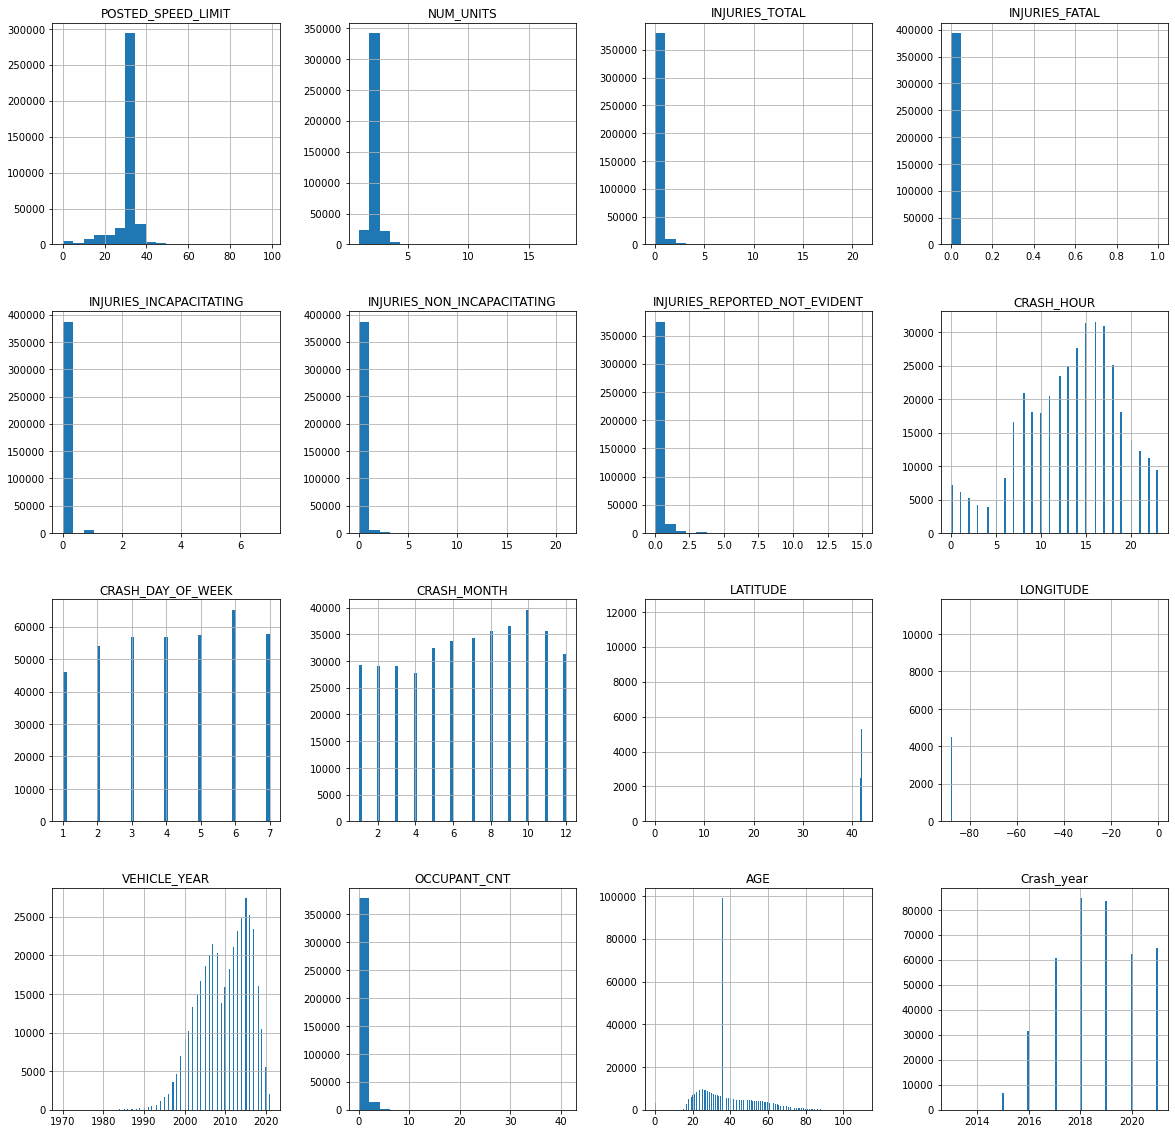

In [21]:
df_driver.hist(figsize=(20,20), bins='auto');

In [22]:
columns_to_drop = ['CRASH_RECORD_ID','CRASH_DATE_x','INJURIES_TOTAL','INJURIES_INCAPACITATING',
                   'INJURIES_NON_INCAPACITATING','INJURIES_REPORTED_NOT_EVIDENT','MAKE','MOST_SEVERE_INJURY',
                   'MODEL','VEHICLE_YEAR','OCCUPANT_CNT','PERSON_TYPE',
                   'INJURY_CLASSIFICATION','CRASH_TYPE','LONGITUDE','LATITUDE','Crash_year','CRASH_MONTH']

df_driver = df_driver.drop(columns_to_drop,axis=1)

In [23]:
df_driver.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394225 entries, 0 to 2652377
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   POSTED_SPEED_LIMIT       394225 non-null  int64  
 1   TRAFFIC_CONTROL_DEVICE   394225 non-null  object 
 2   DEVICE_CONDITION         394225 non-null  object 
 3   WEATHER_CONDITION        394225 non-null  object 
 4   LIGHTING_CONDITION       394225 non-null  object 
 5   FIRST_CRASH_TYPE         394225 non-null  object 
 6   TRAFFICWAY_TYPE          394225 non-null  object 
 7   ALIGNMENT                394225 non-null  object 
 8   ROADWAY_SURFACE_COND     394225 non-null  object 
 9   ROAD_DEFECT              394225 non-null  object 
 10  DAMAGE                   394225 non-null  object 
 11  PRIM_CONTRIBUTORY_CAUSE  394225 non-null  object 
 12  SEC_CONTRIBUTORY_CAUSE   394225 non-null  object 
 13  NUM_UNITS                394225 non-null  int64  
 14  INJ

In [24]:
df_driver.describe()

,POSTED_SPEED_LIMIT,NUM_UNITS,INJURIES_FATAL,CRASH_HOUR,CRASH_DAY_OF_WEEK,AGE
count,394225.000000,394225.000000,394225.000000,394225.000000,394225.000000,394225.000000
mean,28.537168,2.031928,0.001081,13.355028,4.145140,38.447011
std,6.242392,0.466482,0.032855,5.364024,1.961999,14.434861
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,30.000000,2.000000,0.000000,10.000000,2.000000,29.000000
50%,30.000000,2.000000,0.000000,14.000000,4.000000,36.000000
75%,30.000000,2.000000,0.000000,17.000000,6.000000,46.000000
max,99.000000,18.000000,1.000000,23.000000,7.000000,110.000000


In [25]:
df_driver.shape

(394225, 27)

In [26]:
df_driver.PRIM_CONTRIBUTORY_CAUSE.value_counts()

UNABLE TO DETERMINE                                                                 127332
FAILING TO YIELD RIGHT-OF-WAY                                                        49379
FOLLOWING TOO CLOSELY                                                                46437
FAILING TO REDUCE SPEED TO AVOID CRASH                                               19150
IMPROPER OVERTAKING/PASSING                                                          18897
IMPROPER BACKING                                                                     18580
NOT APPLICABLE                                                                       17298
IMPROPER LANE USAGE                                                                  15821
IMPROPER TURNING/NO SIGNAL                                                           14765
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  13334
DISREGARDING TRAFFIC SIGNALS                                                          7797

In [27]:
df_driver = df_driver[df_driver.PRIM_CONTRIBUTORY_CAUSE != 'UNABLE TO DETERMINE']
df_driver.shape

(266893, 27)

In [28]:
df_driver.SEC_CONTRIBUTORY_CAUSE.value_counts()

NOT APPLICABLE                                                                      111293
UNABLE TO DETERMINE                                                                  57093
FAILING TO REDUCE SPEED TO AVOID CRASH                                               17918
FAILING TO YIELD RIGHT-OF-WAY                                                        12926
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  12567
FOLLOWING TOO CLOSELY                                                                11519
IMPROPER OVERTAKING/PASSING                                                           5835
IMPROPER LANE USAGE                                                                   5710
WEATHER                                                                               5192
IMPROPER TURNING/NO SIGNAL                                                            4342
IMPROPER BACKING                                                                      3523

In [29]:
# df_driver = df_driver[(df_driver.SEC_CONTRIBUTORY_CAUSE != 'UNABLE TO DETERMINE')]
# df_driver = df_driver[(df_driver.SEC_CONTRIBUTORY_CAUSE != 'NOT APPLICABLE')]
# df_driver.shape

In [30]:
# X = df_driver.drop('INJURIES_FATAL',axis=1)
# y = df_driver.INJURIES_FATAL

# X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [31]:
# Ohe-ing Train set
# X_train_cat = X_train.select_dtypes('object')

# ohe = OneHotEncoder(
#     drop='first',
#     sparse=False)

# dums = ohe.fit_transform(X_train_cat)
# dums_df = pd.DataFrame(dums,
#                        columns=ohe.get_feature_names(),
#                        index=X_train_cat.index)

# nums_df = X_train.select_dtypes(['int64','float64'])

# X_train_clean = pd.concat([nums_df, dums_df], axis=1)

In [32]:
# Ohe-ing Test set
# X_test_cat = X_test.select_dtypes('object')

# ohe = OneHotEncoder(
#     drop='first',
#     sparse=False)

# dums = ohe.fit_transform(X_test_cat)
# dums_df = pd.DataFrame(dums,
#                        columns=ohe.get_feature_names(),
#                        index=X_test_cat.index)

# nums_df = X_test.select_dtypes(['int64','float64'])

# X_test_clean = pd.concat([nums_df, dums_df], axis=1)